In [1]:
from itertools import product

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Prepare MNIST data

In [2]:
height = 28
width = 28
raw_image_channel = 1
pixels = height*width*raw_image_channel
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Fully connected layer

In [3]:
def initial_weight(shape):
    return tf.get_variable('W', shape=shape, initializer=tf.truncated_normal_initializer(stddev=0.1))

def initial_bias(shape):
    return tf.get_variable('b', shape=shape, initializer=tf.constant_initializer(value=0.1))

def fc_layer(bottom, width, name):
    input_size = bottom.shape[-1]
    with tf.variable_scope(name):
        w = initial_weight([input_size, width])
        b = initial_bias(width)
        s = tf.matmul(bottom, w) + b
    return s

## Build autoencoder with 32 codes

In [4]:
def autoencoder(x, act_fn):
    s = fc_layer(x, 32, 'encoder')
    if act_fn == 'relu':
        code = tf.nn.relu(s)
    elif act_fn == 'sigmoid':
        code = tf.sigmoid(s)
    else:
        raise NotImplementedError
    logits = fc_layer(code, pixels, 'decoder')
    x_construct = tf.sigmoid(logits)
    return logits, x_construct

## Loss function

In [5]:
def evaluate(x, logits, x_construct, loss_type):
    if loss_type=='mse':
        loss = tf.losses.mean_squared_error(x, x_construct)
    elif loss_type=='cross-entropy':
        loss = tf.losses.sigmoid_cross_entropy(x, logits)
    else:
        raise NotImplementedError
    return loss

## Build computation graph

In [6]:
def build_graph(act_fn, loss_type, optimizer, lr):
    x = tf.placeholder(tf.float32, [None, pixels], name='x')
    logits, x_construct = autoencoder(x, act_fn)
    loss = evaluate(x, logits, x_construct, loss_type)
    if optimizer == 'Adam':
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    elif optimizer == 'Adadelta':
        train_step = tf.train.AdadeltaOptimizer(lr).minimize(loss)
    else:
        raise NotImplementedError
    return x, logits, x_construct, loss, train_step

## Helper function (concatenate images)

In [7]:
def append_image(raw_x, res_x):
    n = raw_x.shape[0]
    raw_im = np.reshape(raw_x, [-1, height, width])
    res_im = np.reshape(res_x, [-1, height, width])
    raw_im_concate = np.concatenate([raw_im[i,:,:] for i in range(n)], axis=1)
    res_im_concate = np.concatenate([res_im[i,:,:] for i in range(n)], axis=1)
    out_im = np.concatenate([raw_im_concate, res_im_concate], axis=0)
    return out_im

In [8]:
def train_and_demo(act_fn, loss_type, optimizer, lr):
    history_loss = {}
    tf.reset_default_graph()
    x, logits, x_construct, loss, train_step = build_graph(act_fn, loss_type, optimizer, lr)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(10001):
        batch = mnist.train.next_batch(256)
        if i % 1000 == 0:
            train_loss = sess.run(loss, feed_dict={x: mnist.train.images})
            history_loss[i] = train_loss
        sess.run(train_step, feed_dict={x: batch[0]})
    
    # show reconstruct images
    raw_x = mnist.test.images[0:5,:]
    res_x = sess.run(x_construct, {x:raw_x})
    concate_im = append_image(raw_x, res_x)
    return concate_im, history_loss

In [10]:
act_fns = ['relu', 'sigmoid']
loss_types = ['mse', 'cross-entropy']
optimizers = ['Adam', 'Adadelta']
lrs = [1, 1e-3]

result = {}
hyperparameters = product(act_fns, loss_types, optimizers, lrs)
for x in hyperparameters:
    print(x)
    out = train_and_demo(x[0], x[1], x[2], x[3])
    result[x] = out

('relu', 'mse', 'Adam', 1)
('relu', 'mse', 'Adam', 0.001)
('relu', 'mse', 'Adadelta', 1)
('relu', 'mse', 'Adadelta', 0.001)
('relu', 'cross-entropy', 'Adam', 1)
('relu', 'cross-entropy', 'Adam', 0.001)
('relu', 'cross-entropy', 'Adadelta', 1)
('relu', 'cross-entropy', 'Adadelta', 0.001)
('sigmoid', 'mse', 'Adam', 1)
('sigmoid', 'mse', 'Adam', 0.001)
('sigmoid', 'mse', 'Adadelta', 1)
('sigmoid', 'mse', 'Adadelta', 0.001)
('sigmoid', 'cross-entropy', 'Adam', 1)
('sigmoid', 'cross-entropy', 'Adam', 0.001)
('sigmoid', 'cross-entropy', 'Adadelta', 1)
('sigmoid', 'cross-entropy', 'Adadelta', 0.001)


In [15]:
result.keys()

dict_keys([('relu', 'mse', 'Adam', 1), ('relu', 'mse', 'Adam', 0.001), ('relu', 'mse', 'Adadelta', 1), ('relu', 'mse', 'Adadelta', 0.001), ('relu', 'cross-entropy', 'Adam', 1), ('relu', 'cross-entropy', 'Adam', 0.001), ('relu', 'cross-entropy', 'Adadelta', 1), ('relu', 'cross-entropy', 'Adadelta', 0.001), ('sigmoid', 'mse', 'Adam', 1), ('sigmoid', 'mse', 'Adam', 0.001), ('sigmoid', 'mse', 'Adadelta', 1), ('sigmoid', 'mse', 'Adadelta', 0.001), ('sigmoid', 'cross-entropy', 'Adam', 1), ('sigmoid', 'cross-entropy', 'Adam', 0.001), ('sigmoid', 'cross-entropy', 'Adadelta', 1), ('sigmoid', 'cross-entropy', 'Adadelta', 0.001)])

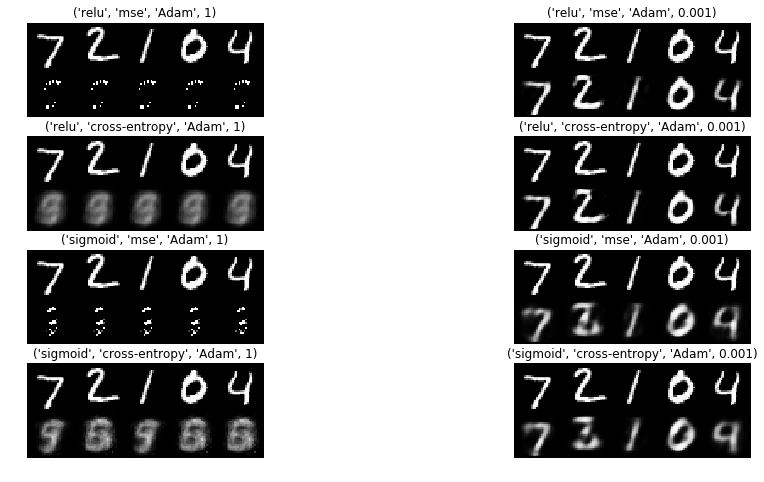

In [23]:
adam = [x for x in result.keys() if x[2]=='Adam']
plt.figure(figsize=(16,8))
for i, x in enumerate(adam,1):
    plt.subplot(420+i)
    plt.imshow(result[x][0], 'gray')
    plt.axis('off')
    plt.title(x)
plt.show()

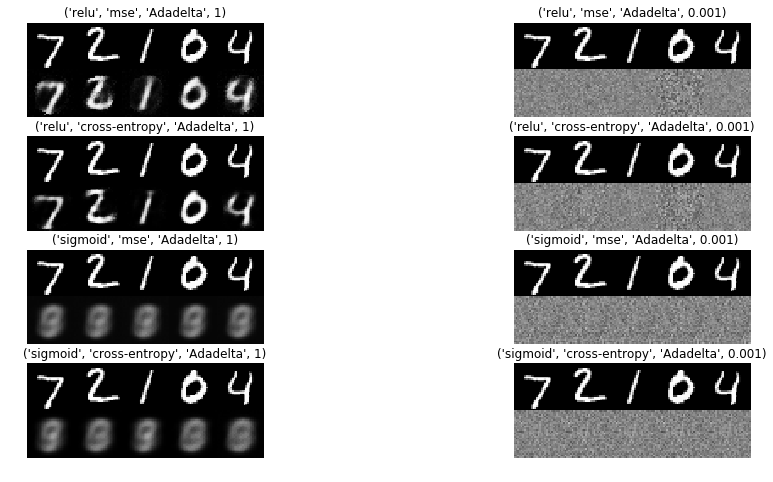

In [24]:
adadelta = [x for x in result.keys() if x[2]=='Adadelta']
plt.figure(figsize=(16,8))
for i, x in enumerate(adadelta,1):
    plt.subplot(420+i)
    plt.imshow(result[x][0], 'gray')
    plt.axis('off')
    plt.title(x)
plt.show()

## Conclusion

* Use "relu" as hidden layer activation function rather than "sigmoid".
* The best learning rate range depends on your optimizer algorithm. (Adam: 1e-3, Adadelta: 1)
* Loss function "mse" & "cross-entropy" looks no significant difference in the autoencoder task.

## Reference

* https://gertjanvandenburg.com/blog/autoencoder/
* https://www.reddit.com/r/MachineLearning/comments/1tym0s/relu_for_autoencoder/
* http://www.ycc.idv.tw/YCNote/post/43